# Лабораторная работа №4: "Поиск пути в среде с преградами"

---

## Дано

Клеточное поле размером $m \times n$. Шаг между соседними клетками равен 1.

Поле заполнено заданным числом препятствий, расположенных случайным образом.
Каждое препятствие имеет единичную ширину и случайную длину в диапазоне длин от $l_{min}$ до $l_{max}$, выбираемую из равномерного распределения. Ориентация (горизонтальная или вертикальная) преграды на поле выбирается также случайным образом.

В районе левой части поля случайным образом выбирается свободная клетка. Обозначается как точка ${\bf P}_0$. В правой части аналогичным образом определяется точка ${\bf P}_1$.

* Размеры левой области, где генерируется точка ${\bf P} _0$:
  $x_{min}^{left} = 0$,
  $x_{max}^{left} = \left\lfloor n/5 \right\rfloor$,
  $y_{min}^{left} = 0$,
  $y_{max}^{left} = m$.
* Размеры правой области, где генерируется точка ${\bf P} _1$:
  $x_{min}^{right} = n - \left\lfloor n/5 \right\rfloor$,
  $x_{max}^{right} = n$,
  $y_{min}^{right} = 0$,
  $y_{max}^{right} = m$.

**Замечания:**

* Из каждой клетки возможны 4 перемещения: вверх, вправо, вниз, влево.

## Требуется

1. Найти кратчайший путь из точки ${\bf P}_0$ в точку ${\bf P}_1$, используя алгоритм эвристического поиска A*.
2. Показать решение графически.

## Требования к отчёту

1. Титульный лист.
2. Цели и задачи лабораторной работы (ЛР).
3. Теоретическая часть:
   * описание алгоритма решения задачи поиска пути;
   * достоинства и недостатки алгоритма.
4. Практическая часть:
   * описание полученных результатов (длина кратчайшего пути при различных значениях веса `w` эвристической функции);
   * графики.
5. Заключение.

**Цель** - получить опыт решения задачи поиска кратчайшего пути в дискретном двумерном пространстве с препятствиями.

**Задачи:**

1. Найти кратчайший путь из точки ${\bf P}_0$ в точку ${\bf P}_1$, используя алгоритм эвристического поиска A*.
2. Показать решение графически.

Проверяет лабы Федулов В.А.

## Пример оформления графика

![Пример оформления графика](plot_example.png)

In [1]:
import numpy as np
from numpy.random import Generator, PCG64
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from dataclasses import dataclass, field
from typing import Optional

In [372]:
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True

**Класс `Node` для представления информации в кажой ячейке сетки в виде набора координат, родительской ячейки (т.е. той, откуда мы пришли в текущую), значения *f* и параметра `value`, характеризующего тип ячейки (0 - свободная, 1 - преграда, 2 - старт/часть пути, 3 - цель)**

In [3]:
@dataclass
class Node:
    x: int
    y: int
    parent: Optional[object] = field(default=None)
    value: Optional[int] = field(default=0)
    f: Optional[int] = field(default=0)

**Класс `Grid` для работы с лабиринтом**

In [373]:
class Grid:
    sizeMax = 1000
    sizeMin = 10
    lobsMax = 7
    lobsMin = 1
    
    def __init__(self, *, m, n, n_obs, l_obs_lims, start_lims, goal_lims):
        if m > self.sizeMax:
            print("Значение m изменено на максимально возможное:", self.sizeMax)
        if m < self.sizeMin:
            print("Значение m изменено на минимально возможное:", self.sizeMin)
        if n > self.sizeMax:
            print("Значение n изменено на максимально возможное:", self.sizeMax)
        if n < self.sizeMin:
            print("Значение n изменено на минимально возможное:", self.sizeMin)           
        if min(l_obs_lims) < self.lobsMin:
            print("Значение l_obs_min изменено на минимально возможное:", self.lobsMin)
        if max(l_obs_lims) > self.lobsMax:
            print("Значение l_obs_max изменено на максимально возможное:", self.lobsMax)
        self.m = self.sizeMax if m > self.sizeMax else max(m, self.sizeMin)
        self.n = self.sizeMax if n > self.sizeMax else max(n, self.sizeMin)
        self.l_max = min(max(l_obs_lims), self.lobsMax)
        self.l_min = max(min(l_obs_lims), self.lobsMin)
        self.n_obs = n_obs
        self.__grid = np.full((self.n, self.m), None)
        self.rs = None
        self.start_lims = start_lims
        self.goal_lims = goal_lims
        self.start = None
        self.goal = None
    
    @property    
    def grid(self):
        return self.__grid
    
    def build(self, seed=None, show=False):
        self.rs = Generator(PCG64(seed))
        for i in range(self.m):
            for j in range(self.n):
                self.__grid[j][i] = Node(x=i, y=j)
        for _ in range(self.n_obs):
            self._genObs() 
        self._gen_start()
        self._gen_goal()
        if show:
            self.plot(self.__grid)
            
    def get_neighbors(self, node):
        neighbors = np.array([])
        if node.x < self.m - 1:
            neighbors = np.append(neighbors, self.__grid[node.y][node.x + 1])
        if node.x > 0:
            neighbors = np.append(neighbors, self.__grid[node.y][node.x - 1])
        if node.y < self.n - 1:
            neighbors = np.append(neighbors, self.__grid[node.y + 1][node.x])
        if node.y > 0: 
            neighbors = np.append(neighbors, self.__grid[node.y - 1][node.x])
        return neighbors
    
    def get_start(self):
        return self.start
    
    def get_goal(self):
        return self.goal    
    
    def _gen_start(self):
        while True:
            x = self.rs.integers(low=min(self.start_lims[0]), high=max(self.start_lims[0]))
            y = self.rs.integers(low=min(self.start_lims[1]), high=max(self.start_lims[1]))
            if self.__grid[y][x] != 1:
                self.__grid[y][x].y = y
                self.__grid[y][x].x = x
                self.__grid[y][x].value = 2
                self.start = self.__grid[y][x]
                return
    
    def _gen_goal(self):
        while True:
            x = self.rs.integers(low=min(self.goal_lims[0]), high=max(self.goal_lims[0]))
            y = self.rs.integers(low=min(self.goal_lims[1]), high=max(self.goal_lims[1]))
            if self.__grid[y][x] != 1:
                self.__grid[y][x].y = y
                self.__grid[y][x].x = x
                self.__grid[y][x].value = 3
                self.goal = self.__grid[y][x]
                return
    
    def _genObs(self):
        l = round(self.rs.uniform(low=self.l_min, high=self.l_max))
        coin = self.rs.integers(low=0, high=2)
        if coin > 0:
            col = self.rs.integers(low=0, high=self.n - 1)
            y0 = self.rs.integers(low=0, high=self.m - 1 - l)
#             print(self.__grid[col][y0:y0 + l])
            for i in range(l):
                self.__grid[col][y0:y0 + l][i].value = 1
            return
        raw = self.rs.integers(low=0, high=self.m - 1)
        x0 = self.rs.integers(low=0, high=self.n - 1 - l)
#         print(self.__grid.T[raw][x0:x0 + l])
        for i in range(l):
            self.__grid.T[raw][x0:x0 + l][i].value = 1
        return
                          
    def plot(self, figsize=(6, 6), dpi=120, **kw):
        colors = ["white", "black", "blue", "red"]
        cmap = ListedColormap(colors)
        
        field = np.zeros_like(self.__grid, dtype=np.int32)
        for i in range(self.m):
            for j in range(self.n):
                field[j][i] = self.__grid[j][i].value
#         print(field)
        fig = plt.figure(figsize=figsize, dpi=dpi, facecolor='white')
        plt.imshow(field, cmap=cmap)
        plt.xlabel('m')
        plt.ylabel('n')
        if 'path_length' and 'w' in kw:
            plt.title("Длина пути: {} (w = {})".format(kw['path_length'], kw['w']))
            plt.savefig(f"plotw{kw['w']}")
        plt.show()

# <center>АЛГОРИТМ</center>
![Алгоритм](algorithm.png)

In [374]:
def heuristic(node1, node2):
    return abs(node1.x - node2.x) + abs(node1.y - node2.y)

In [375]:
def extract(node):
    path = []
    while node.parent:
        path.append(node.parent)
        node = node.parent
    return path

In [376]:
def find_path(w=1, seed=None):

    grid = Grid(m=m, n=n, n_obs=n_obs, l_obs_lims=l_obs_lims, start_lims=start_lims, goal_lims=goal_lims)
    grid.build(seed=seed)
#     grid.plot()

    open_set = []
    closed_set = []

    start = grid.get_start()
    goal = grid.get_goal()
    h = heuristic(start, goal)

    start.f = w * h

    open_set.append(start)

    while True:
        current = min(open_set, key=lambda node: node.f)
        neighbors = grid.get_neighbors(current)
        open_set.remove(current)
        closed_set.append(current)

        if current == goal:
            path = extract(current)
            for node in path:
                grid.grid[node.y][node.x].value = 2
            grid.plot(path_length=len(path), w=w)
            
#             print("start", start.x, start.y)
#             print("goal", goal.x, goal.y)
            return # current.f

        for neighbor in neighbors:
            if neighbor in closed_set or neighbor.value == 1:
                continue
            f = heuristic(neighbor, start) + w * heuristic(neighbor, goal)
            if neighbor not in open_set or neighbor in open_set and f < neighbor.f:
                neighbor.f = f
                neighbor.parent = current
                if neighbor not in open_set:
                    open_set.append(neighbor)

In [379]:
m, n = 100, 100
n_obs = 300
l_obs_lims = 2, 7
start_lims = [0, n // 5], [0, m]
goal_lims = [n - n // 5, n], [0, m]

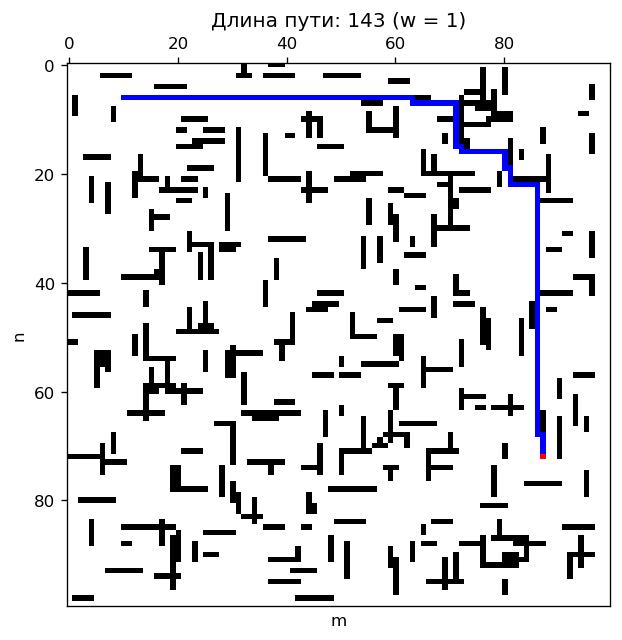

CPU times: total: 17.8 s
Wall time: 17.8 s


In [386]:
%%time
find_path(w=1, seed=None)